In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
len(df)

7613

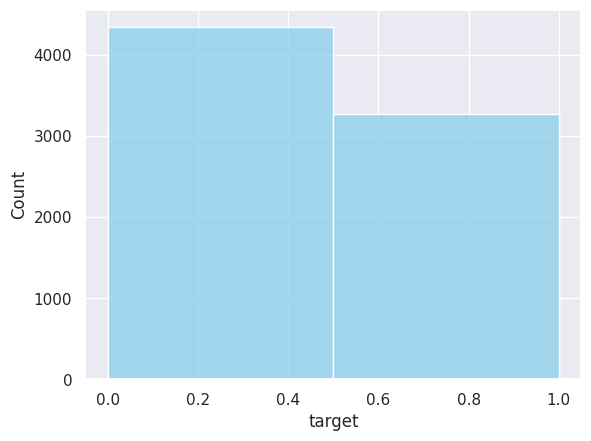

In [4]:
sns.set(style="darkgrid")
sns.histplot(data=df, x="target", color="skyblue", binwidth=1/2)
plt.show()

In [5]:
print(f"{round(1000 * np.min(pd.DataFrame(df['target']).value_counts().values)/len(df))/10}% of dataset belongs to minority class")

43.0% of dataset belongs to minority class


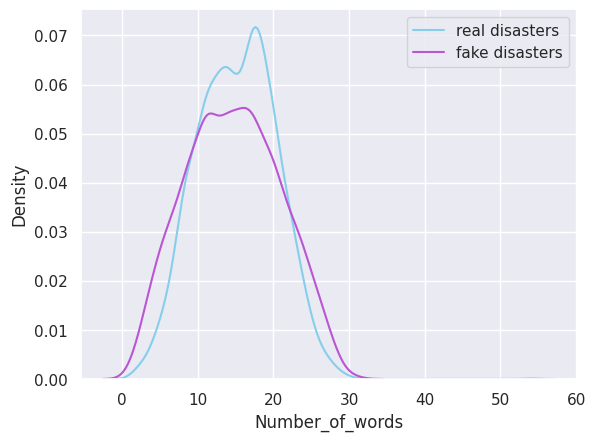

In [6]:
df["Number_of_words"] = df.text.map(lambda x: len(x.split(" ")))


sns.set(style="darkgrid")
sns.kdeplot(data=df[df.target==1], x="Number_of_words", color="skyblue", label = "real disasters")
sns.kdeplot(data=df[df.target!=1], x="Number_of_words", color="mediumorchid", label = "fake disasters")
plt.legend()
plt.show()

## Generate more datasets

In [7]:
from sklearn.model_selection import train_test_split

### Train test split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
df_train = pd.merge(X_train, y_train, left_index=True, right_index=True)

In [8]:
from imblearn.under_sampling import RandomUnderSampler
import random

datasets = {"original": (X_train,y_train)}

df_minority = df_train[df_train.target == 1]
df_majority = df_train[df_train.target == 0]


### balanced
df_majority_bal = df_majority.sample(len(df_minority))
df_bal = pd.concat([df_majority_bal,df_minority])
datasets["balanced"] = (df_bal.text, df_bal.target)

# imbalanced
n = len(df_majority_bal)

for perc in [95, 90, 75, 50, 25]:
    df_min = df_minority.sample(int(n*perc/100))
    df_bal = pd.concat([df_majority_bal,df_min])
    datasets[f"{perc}%"] = (df_bal.text, df_bal.target)

In [9]:
datasets.keys()

dict_keys(['original', 'balanced', '95%', '90%', '75%', '50%', '25%'])

## Modelling

In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

device_cpu = torch.device("cpu")

In [11]:
import transformers
from transformers import AutoModel, BertTokenizerFast, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils.class_weight import compute_class_weight


class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
    
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
    
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
    
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
    
        # apply softmax activation
        x = self.softmax(x)

        return x

 # function to train the model
def train(model, train_dataloader, device, cross_entropy, optimizer):
    
    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds, model

def train_bert(batch_size = 32, epochs = 10, datasets = {}, dataset = "original", tokenizer="", weights = True, val_seq = None, val_y=None, val_mask=None):
    # specify GPU
    device = torch.device("cuda")

    # import BERT-base pretrained model
    bert = AutoModel.from_pretrained('bert-base-uncased')

    

    # tokenize and encode sequences in the training set
    train_text = datasets[dataset][0]
    train_labels = datasets[dataset][1]

    tokens_train = tokenizer.batch_encode_plus(
        train_text.tolist(),
        max_length = 40,
        pad_to_max_length=True,
        truncation=True
    )

    ## convert lists to tensors
    train_seq = torch.tensor(tokens_train['input_ids'])
    train_mask = torch.tensor(tokens_train['attention_mask'])
    train_y = torch.tensor(train_labels.tolist())

    # wrap tensors
    train_data = TensorDataset(train_seq, train_mask, train_y)

    # sampler for sampling the data during training
    train_sampler = RandomSampler(train_data)

    # dataLoader for train set
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # freeze all the parameters
    for param in bert.parameters():
        param.requires_grad = False
        
    # pass the pre-trained BERT to our define architecture
    model = BERT_Arch(bert)

    # push the model to GPU
    model = model.to(device)

    # define the optimizer
    optimizer = AdamW(model.parameters(),lr = 1e-5) 

    #compute the class weights
    if weights:
        classes = np.unique(train_labels)
        class_weights = compute_class_weight(class_weight = 'balanced', classes = classes, y = train_labels.values)
    else:
        class_weights = [1,1]
        
    # converting list of class weights to a tensor
    weights= torch.tensor(class_weights,dtype=torch.float)

    # push to GPU
    weights = weights.to(device)

    # define the loss function
    cross_entropy  = nn.NLLLoss(weight=weights) 

   

    # empty lists to store training and validation loss of each epoch
    train_losses = []
    val_losses = []
    #for each epoch
    for epoch in range(epochs):
        
        #train model
        train_loss, a, model = train(model, train_dataloader, device, cross_entropy, optimizer)
        with torch.no_grad():
            preds = model(val_seq.to(device), val_mask.to(device))
        # append training and validation loss
        train_losses.append(train_loss)
        val_loss = cross_entropy(preds, val_y.to(device))
        val_y = val_y.detach().cpu()
        preds = preds.detach().cpu()
        val_seq = val_seq.detach().cpu()
        val_mask = val_mask.detach().cpu()
        if len(val_losses)>0 and val_loss>val_losses[-1]+1e-5:
            break
        val_losses.append(val_loss)
    
        
        
    
    return model, train_losses, val_losses


In [12]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
    
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = 40,
    pad_to_max_length=True,
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    X_val.tolist(),
    max_length = 40,
    pad_to_max_length=True,
    truncation=True
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
## convert lists to tensors
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

### Main model

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

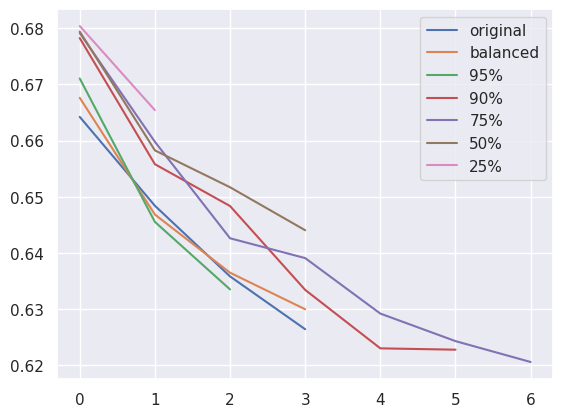

In [14]:
import matplotlib.pyplot as plt
models = []

### With weights
for dataset in datasets.keys():
    model, train_losses, val_losses = train_bert(batch_size = 32, epochs = 25, datasets = datasets, dataset = dataset, tokenizer = tokenizer,  val_seq = val_seq, val_y=val_y, val_mask=val_mask)
    models.append(model)
    plt.plot(train_losses, label=dataset)
plt.legend()
plt.show()

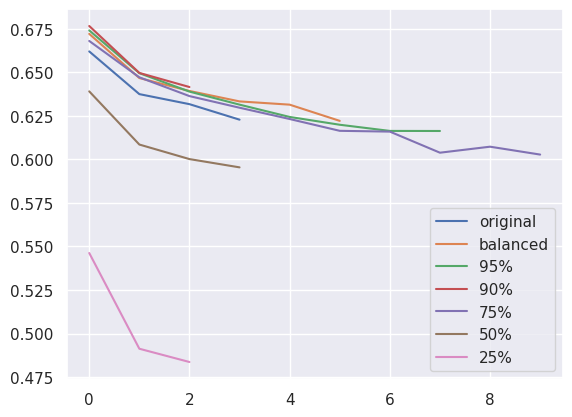

In [15]:
### Without weights
model_wo_weights = []
for dataset in datasets.keys():
    model, train_losses, val_losses = train_bert(batch_size = 32, epochs = 25, datasets = datasets, dataset = dataset, tokenizer = tokenizer, weights=False,  val_seq = val_seq, val_y=val_y, val_mask=val_mask)
    model_wo_weights.append(model)
    plt.plot(train_losses, label=dataset)
plt.legend()
plt.show()

In [18]:
with torch.no_grad():
        preds = model2(test_seq.to(device_cpu), test_mask.to(device_cpu))
        preds = preds.detach().cpu().numpy()
results = pd.DataFrame(data={"real": test_y, "predicted": np.transpose(np.exp(preds))[1]})

<Axes: xlabel='predicted', ylabel='Count'>

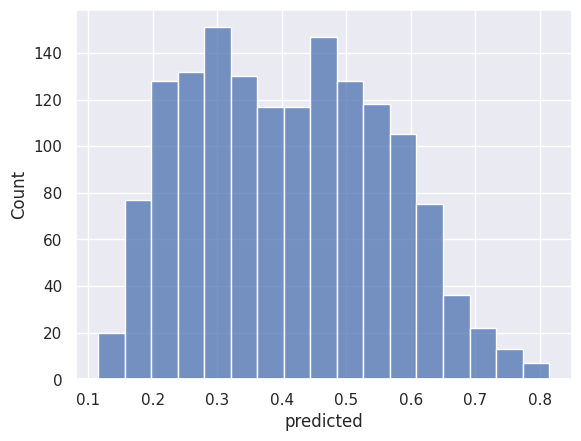

In [19]:
sns.histplot(results, x="predicted")

<Axes: xlabel='predicted', ylabel='Count'>

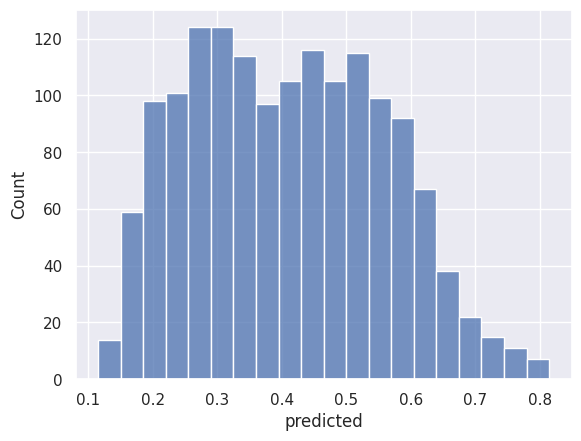

In [20]:
buckets = 20
sns.histplot(results, x="predicted", bins = buckets)

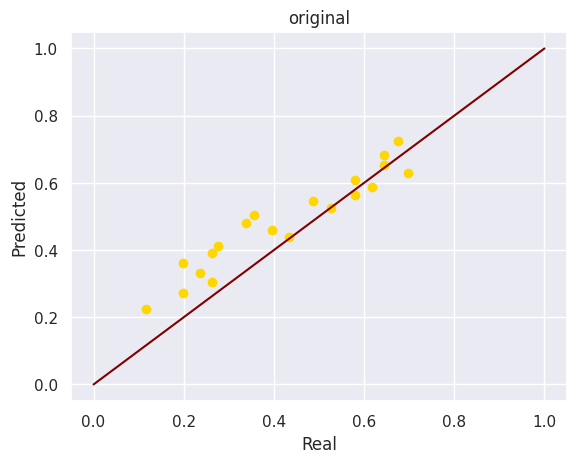

MSE: 0.14981601098036518




_____________________________original_____________________________
              precision    recall  f1-score   support

           0       0.72      0.65      0.69       874
           1       0.59      0.67      0.62       649

    accuracy                           0.66      1523
   macro avg       0.66      0.66      0.66      1523
weighted avg       0.67      0.66      0.66      1523

   
  
  
   


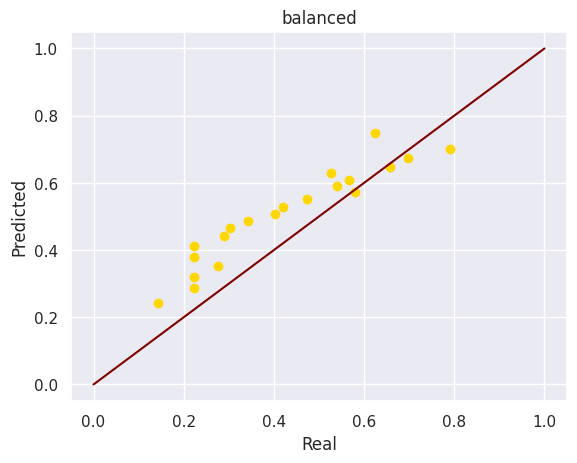

MSE: 0.2277842248460593




_____________________________balanced_____________________________
              precision    recall  f1-score   support

           0       0.75      0.60      0.67       874
           1       0.57      0.73      0.64       649

    accuracy                           0.65      1523
   macro avg       0.66      0.66      0.65      1523
weighted avg       0.67      0.65      0.66      1523

   
  
  
   


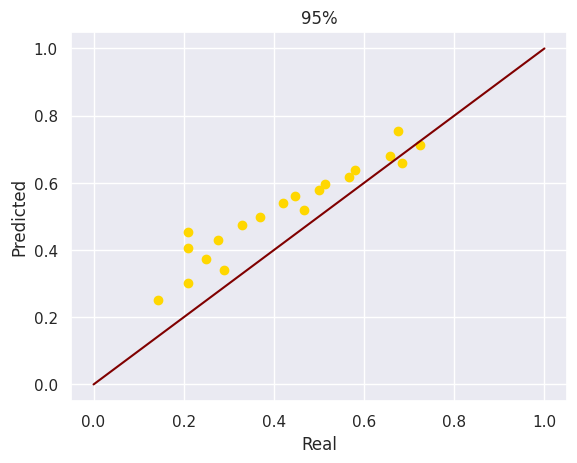

MSE: 0.2532474224547957




_____________________________95%_____________________________
              precision    recall  f1-score   support

           0       0.75      0.56      0.64       874
           1       0.56      0.74      0.64       649

    accuracy                           0.64      1523
   macro avg       0.65      0.65      0.64      1523
weighted avg       0.67      0.64      0.64      1523

   
  
  
   


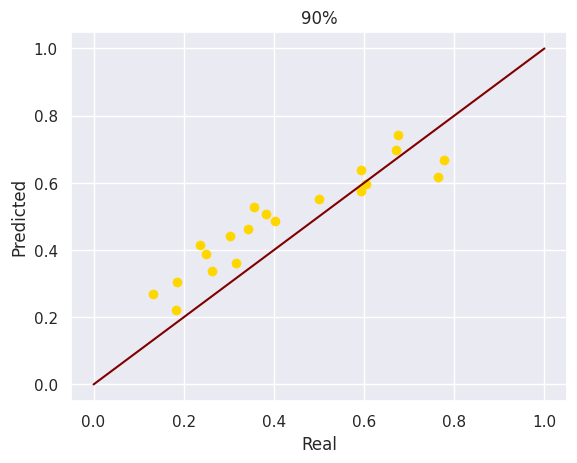

MSE: 0.2245350210973444




_____________________________90%_____________________________
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       874
           1       0.59      0.69      0.64       649

    accuracy                           0.67      1523
   macro avg       0.67      0.67      0.67      1523
weighted avg       0.68      0.67      0.67      1523

   
  
  
   


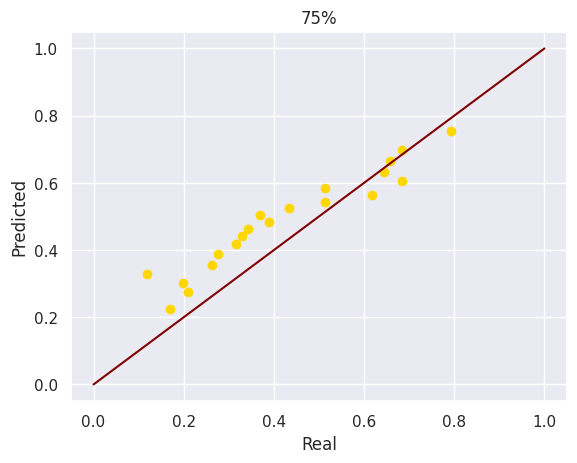

MSE: 0.17477977311924625




_____________________________75%_____________________________
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       874
           1       0.60      0.68      0.64       649

    accuracy                           0.67      1523
   macro avg       0.67      0.67      0.67      1523
weighted avg       0.68      0.67      0.67      1523

   
  
  
   


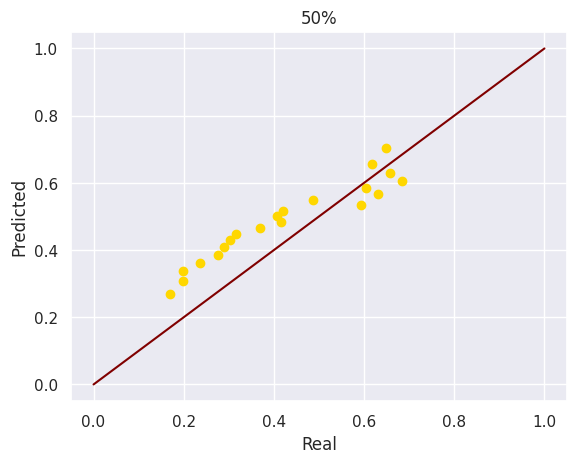

MSE: 0.17183045438216585




_____________________________50%_____________________________
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       874
           1       0.58      0.65      0.61       649

    accuracy                           0.65      1523
   macro avg       0.65      0.65      0.65      1523
weighted avg       0.66      0.65      0.65      1523

   
  
  
   


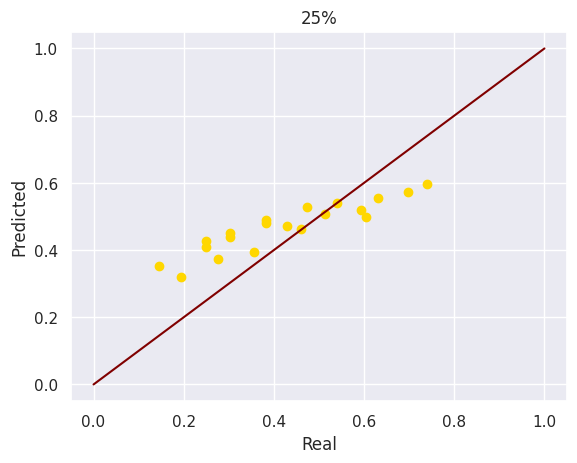

MSE: 0.2521613003573062




_____________________________25%_____________________________
              precision    recall  f1-score   support

           0       0.68      0.75      0.71       874
           1       0.61      0.53      0.56       649

    accuracy                           0.65      1523
   macro avg       0.64      0.64      0.64      1523
weighted avg       0.65      0.65      0.65      1523

   
  
  
   


In [22]:
results = []
for i in range(len(models)):
    model = models[i]
    model2 = model.to(device_cpu)
    with torch.no_grad():
            preds = model2(test_seq.to(device_cpu), test_mask.to(device_cpu))
            preds = preds.detach().cpu().numpy()
    result = pd.DataFrame(data={"real": test_y, "predicted": np.transpose(np.exp(preds))[1]})

    result["bucket"] = 0
    for j in range(1,buckets):
        lower_range = np.quantile(result.predicted,j/buckets)
        result["bucket"] = [result.bucket[j]+1 if result["predicted"][j]>lower_range else result.bucket[j] for j in range(len(result.bucket))]

    stats_for_bucket = result.groupby('bucket').mean()
    
    results.append(result)
    
    plt.plot([0,1],[0,1], color="maroon")
    plt.scatter(stats_for_bucket.real, stats_for_bucket.predicted, color="gold")
    plt.xlabel("Real")
    plt.ylabel("Predicted")
    plt.title(list(datasets.keys())[i])
    plt.show()
    print(f"MSE: {np.sum((stats_for_bucket.real-stats_for_bucket.predicted)**2)}\n\n\n\n")
    
    print(f"_____________________________{list(datasets.keys())[i]}_____________________________")
    print(classification_report(result["real"], (result["predicted"]>1/2).astype(int)))
    print("   \n  \n  \n   ")

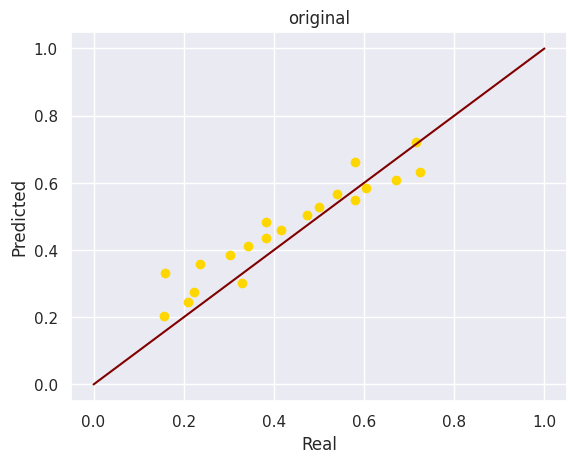

MSE: 0.1020034368291079




_____________________________original_____________________________
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       874
           1       0.60      0.62      0.61       649

    accuracy                           0.66      1523
   macro avg       0.66      0.66      0.66      1523
weighted avg       0.67      0.66      0.66      1523

   
  
  
   


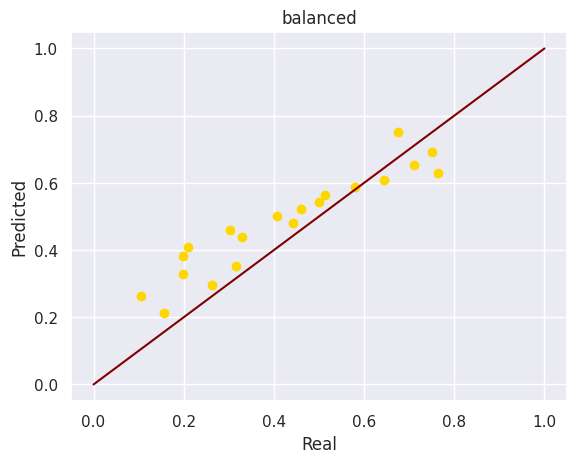

MSE: 0.20768817990129357




_____________________________balanced_____________________________
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       874
           1       0.61      0.68      0.64       649

    accuracy                           0.68      1523
   macro avg       0.68      0.68      0.68      1523
weighted avg       0.69      0.68      0.68      1523

   
  
  
   


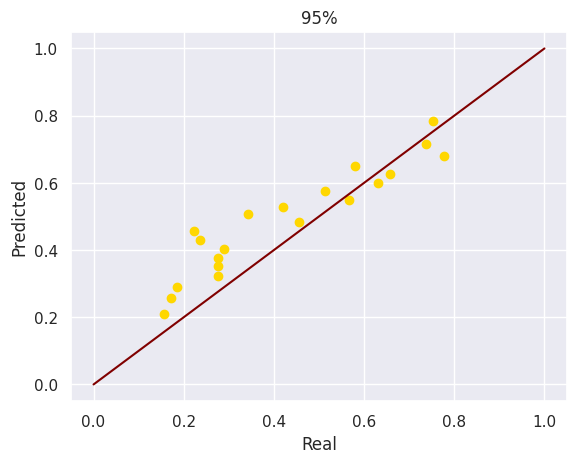

MSE: 0.20447395516090502




_____________________________95%_____________________________
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       874
           1       0.60      0.69      0.64       649

    accuracy                           0.67      1523
   macro avg       0.67      0.68      0.67      1523
weighted avg       0.68      0.67      0.68      1523

   
  
  
   


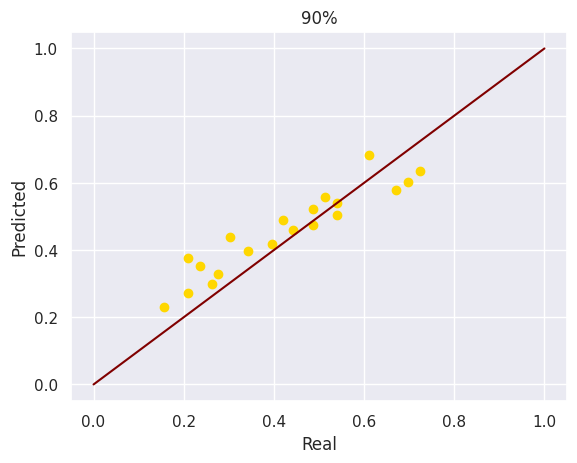

MSE: 0.11668106250047897




_____________________________90%_____________________________
              precision    recall  f1-score   support

           0       0.68      0.72      0.70       874
           1       0.59      0.55      0.57       649

    accuracy                           0.65      1523
   macro avg       0.64      0.63      0.64      1523
weighted avg       0.64      0.65      0.65      1523

   
  
  
   


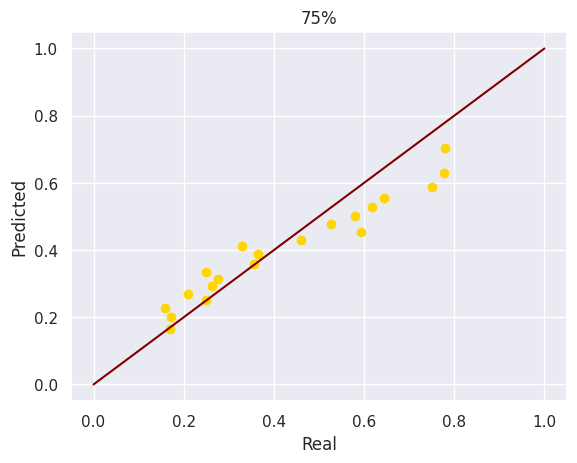

MSE: 0.12467299849389056




_____________________________75%_____________________________
              precision    recall  f1-score   support

           0       0.68      0.86      0.76       874
           1       0.71      0.47      0.56       649

    accuracy                           0.69      1523
   macro avg       0.70      0.66      0.66      1523
weighted avg       0.69      0.69      0.68      1523

   
  
  
   


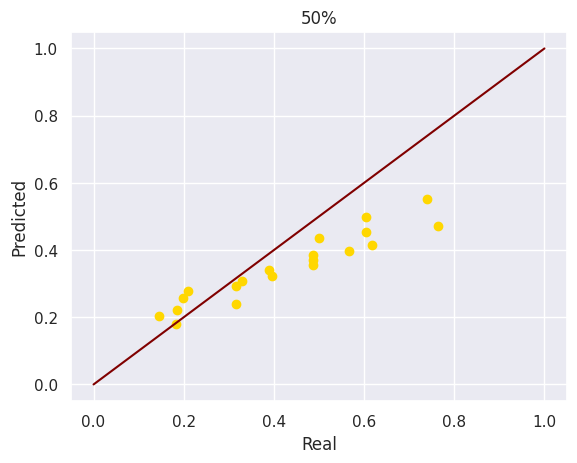

MSE: 0.2964684341947515




_____________________________50%_____________________________
              precision    recall  f1-score   support

           0       0.60      0.96      0.74       874
           1       0.71      0.12      0.21       649

    accuracy                           0.61      1523
   macro avg       0.66      0.54      0.47      1523
weighted avg       0.65      0.61      0.51      1523

   
  
  
   


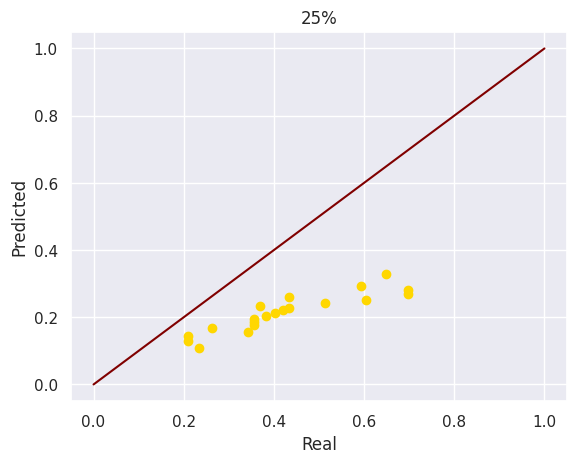

MSE: 1.1047092935758678




_____________________________25%_____________________________
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       874
           1       0.00      0.00      0.00       649

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.42      1523

   
  
  
   


In [24]:
results_wo_weights = []
for i in range(len(models)):
    model = model_wo_weights[i]
    model2 = model.to(device_cpu)
    with torch.no_grad():
            preds = model2(test_seq.to(device_cpu), test_mask.to(device_cpu))
            preds = preds.detach().cpu().numpy()
    result = pd.DataFrame(data={"real": test_y, "predicted": np.transpose(np.exp(preds))[1]})

    result["bucket"] = 0
    for j in range(1,buckets):
        lower_range = np.quantile(result.predicted,j/buckets)
        result["bucket"] = [result.bucket[j]+1 if result["predicted"][j]>lower_range else result.bucket[j] for j in range(len(result.bucket))]

    stats_for_bucket = result.groupby('bucket').mean()
    
    results_wo_weights.append(result)
    
    plt.plot([0,1],[0,1], color="maroon")
    plt.scatter(stats_for_bucket.real, stats_for_bucket.predicted, color="gold")
    plt.xlabel("Real")
    plt.ylabel("Predicted")
    plt.title(list(datasets.keys())[i])
    plt.show()
    print(f"MSE: {np.sum((stats_for_bucket.real-stats_for_bucket.predicted)**2)}\n\n\n\n")
    
    print(f"_____________________________{list(datasets.keys())[i]}_____________________________")
    print(classification_report(result["real"], (result["predicted"]>1/2).astype(int)))
    print("   \n  \n  \n   ")

## T-test

#### $H_0: \overline{X} = \mu$

#### $H_1: \overline{X} \neq \mu$

#### $T=\frac{\overline{X}-\mu}{s}$

#### $s=\sqrt{\frac{\sum_{i=1}^n(X_i-\overline{X})^2}{n-1}}$

#### $df=n-1$

#### p-value$=2(1-K_{df}(|T|))$


In [25]:
from scipy.stats import t


def t_test(pred, real):
    s = np.sqrt((np.sum(pred-np.mean(pred)))**2/(n-1))
    T = (np.mean(pred) - np.mean(real))/s
    df = len(pred)-1
    return 2*(1-t.cdf(np.abs(T),df=df))
    

In [26]:
results

[      real  predicted  bucket
 0        1   0.321729       3
 1        0   0.278522       1
 2        1   0.464980       8
 3        0   0.471877       9
 4        0   0.622095      16
 ...    ...        ...     ...
 1518     0   0.415673       6
 1519     1   0.556109      13
 1520     1   0.683856      18
 1521     1   0.693148      18
 1522     0   0.566991      13
 
 [1523 rows x 3 columns],
       real  predicted  bucket
 0        1   0.326729       2
 1        0   0.409090       5
 2        1   0.389201       4
 3        0   0.432475       6
 4        0   0.653739      16
 ...    ...        ...     ...
 1518     0   0.353814       3
 1519     1   0.594495      13
 1520     1   0.392478       4
 1521     1   0.716587      18
 1522     0   0.458459       7
 
 [1523 rows x 3 columns],
       real  predicted  bucket
 0        1   0.517894       9
 1        0   0.388745       4
 2        1   0.555900      11
 3        0   0.371316       3
 4        0   0.728348      19
 ...    ...   

In [30]:
import scipy
for i in range(len(models)):
    result = results_wo_weights[i]
    print(f"{list(datasets.keys())[i]} p_value: {scipy.stats.ttest_ind(result.predicted, result.real)[1]}") 

original p_value: 0.006045518314145964
balanced p_value: 1.3066027379403828e-05
95% p_value: 1.874307278683404e-06
90% p_value: 0.014293808077528856
75% p_value: 0.09604995409548307
50% p_value: 2.9444785282635692e-09
25% p_value: 2.21232859271968e-59


# Are we looking for just model or can we accept conservative model in favour of minority class

## One sided T-test

#### $H_0: \overline{X} \geq \mu$

#### $H_1: \overline{X} < \mu$

#### $T=\frac{\overline{X}-\mu}{s}$

#### $s=\sqrt{\frac{\sum_{i=1}^n(X_i-\overline{X})^2}{n-1}}$

#### $df=n-1$

#### p-value$=K_{df}(|T|)$

In [32]:

def t_test_1s(pred, real):
    s = np.sqrt((np.sum(pred-np.mean(pred)))**2/(n-1))
    T = (np.mean(pred) - np.mean(real))/s
    df = len(pred)-1
    return t.cdf(T,df=df)

In [31]:
for i in range(len(models)):
    result = results_wo_weights[i]
    print(f"{list(datasets.keys())[i]} p_value: {scipy.stats.ttest_ind(result.predicted, result.real, alternative='less')[1]}") 

original p_value: 0.996977240842927
balanced p_value: 0.9999934669863103
95% p_value: 0.9999990628463606
90% p_value: 0.9928530959612356
75% p_value: 0.048024977047741536
50% p_value: 1.4722392641317846e-09
25% p_value: 1.10616429635984e-59


In [32]:
np.mean(result, axis=0)

real         0.426133
predicted    0.214199
bucket       9.499672
dtype: float64

## Wilcoxon signed-rank test (for large samples >20)

#### $H_0:$ there is no difference between predicted and observed probabilities

#### $H_1:$ there is a difference between predicted and observed probabilities


#### 1) Calculate difference $d$ between observed and predicted probabilities
#### 1.5) Remove observations with $d = 0$
#### 2) We assign ranks based on absolute values of $d$. Ranks are assigned ascending and rank 1 is assigned to smallest $|d|$
#### 3) Calculate sum of ranks for the positive differences($W^+$) and for the negative differences($W^-$)
#### 4) We calculate test statistic as $W=min(W^+,W^-)$
#### 5) Calculate p-value:
#### $s=\sqrt{\frac{N(N-1)(2N+1)-\sum_{i=1}^k\frac{t_i^3-t_i}{2}}{6}}$, where $t_i$ is the number of observations in a group of ties (equal ranks $R_i$) while $k$ is the number of groups
#### For 2 sided hypothesis: p-value = $2(1-\Phi(|\frac{W}{s}|))$
#### For 1 sided hypothesis: p-value = $1-\Phi(\frac{W}{s})$